# Indicatori

In [1]:
## > LIBRARIES
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/prog/functions/')

from ncaa19 import *

sns.set()

## > DATA
path_datasets = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/'
path_elab = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/elaborazioni/'

df_rs_c_res = pd.read_csv(path_datasets + 'RegularSeasonCompactResults.csv')
df_rs_d_res = pd.read_csv(path_datasets + 'RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'Teams.csv')
df_seeds = pd.read_csv(path_datasets + 'NCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'TeamCoaches.csv')
df_tourn = pd.read_csv(path_datasets + 'NCAATourneyCompactResults.csv')
mysub = pd.read_csv(path_datasets + 'SampleSubmissionStage1.csv')
massey = pd.read_csv(path_datasets + 'MasseyOrdinals/MasseyOrdinals.csv')

In [7]:
## > DATA CLEANING
# cleaning seeds
df_seeds_cl = df_seeds.loc[:, ['TeamID', 'Season', 'Seed']]
df_seeds_cl['seed_int'] = df_seeds_cl['Seed'].apply(lambda x: clean_seed(x))
df_seeds_cl['seed_region'] = df_seeds_cl['Seed'].apply(lambda x: extract_seed_region(x))
df_seeds_cl['top_seeded_teams'] = np.where(df_seeds_cl['Seed'].isnull(), 0, 1)
df_seeds_cl.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

# clean team information
df_teams_cl = df_teams.iloc[:,:2]

# create games dataframe WINNERS
df_games_w = prepare_stats_extended_winners(df_in=df_rs_d_res.copy(), 
                                            df_seed_in=df_seeds_cl.copy(), 
                                            df_teams_in=df_teams_cl.copy())

# create games dataframe LOSERS
df_games_l = prepare_stats_extended_losers(df_in=df_rs_d_res.copy(), 
                                           df_seed_in=df_seeds_cl.copy(), 
                                           df_teams_in=df_teams_cl.copy())

# merge both winners and losers dataset
df_games_t = pd.concat([df_games_w,df_games_l], sort=True)

# aggregating by teams and seasons
df_agg_stats = df_games_t.\
                          groupby([df_games_t['Season'], 
                                   df_games_t['TeamID'],
                                   df_games_t['TeamName'],
                                   df_games_t['seed_int'],
                                   df_games_t['seed_region']], 
                                  as_index=False).\
                          apply(aggr_stats).\
                          reset_index()


df_agg_stats['w_pct'] = df_agg_stats['W'] / df_agg_stats['G']
df_agg_stats['w_pct_H'] = df_agg_stats['W_H'] / df_agg_stats['G_H']
df_agg_stats['w_pct_N'] = df_agg_stats['W_N'] / df_agg_stats['G_N']
df_agg_stats['w_pct_last30D'] = df_agg_stats['W_last30D'] / df_agg_stats['G_last30D']
df_agg_stats['w_pct_first30D'] = df_agg_stats['W_first30D'] / df_agg_stats['G_first30D']
df_agg_stats['w_pct_index'] = df_agg_stats['w_pct_last30D'] - df_agg_stats['w_pct_first30D']

df_agg_stats['w_pct_vs_topseeds'] = df_agg_stats['W_vs_topseeds'] / df_agg_stats['G_vs_topseeds']

# cleaning coach stats
coaches_stats = prepare_stats_coach(df_coach_in = coaches, 
                                    df_tourn_in = df_tourn, 
                                    df_stats_agg_in = df_agg_stats)

# cleaning massey ordinals
massey_exploded = prepare_massey_ord(massey)

# cleaning tournament data
regressors = ['poss_m',
              'opp_poss_m',
              'ass_ratio_m',
              'tov_ratio_m',
              'reb_rate_m',
              'opp_true_fg_pct_m',
              'off_rating_m',
              'def_rating_m',
              'net_rating_m',
              'pace_m' ,
              'poss_s',
              'opp_poss_s',
              'ass_ratio_s',
              'tov_ratio_s',
              'reb_rate_s',
              'opp_true_fg_pct_s',
              'off_rating_s',
              'def_rating_s',
              'net_rating_s',
              'pace_s',
              'w_pct_index',
              'seed_int',
              'w_pct', 'w_pct_H', 'w_pct_N',
              'w_pct_vs_topseeds']

df_tourn_cl = prepare_tournament_datasets(df_tourn_in=df_tourn.copy(), 
                                          df_agg_stats_in=df_agg_stats.copy(), 
                                          df_coach_in=coaches_stats, 
                                          df_massey_in=massey_exploded,
                                          list_feat_in = regressors) 

y_ok = [2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014,
        2015, 2016, 2017, 2018]

df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin(y_ok))].reindex()

In [ ]:
## > DATA VIZ TOURNEY 1
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_1 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_poss_m', 'delta_opp_poss_m',
                                         'delta_ass_ratio', 'delta_tov_ratio', 
                                         'delta_reb_rate',
                                         'delta_opp_true_fg_pct', 'delta_c_N_champ_W']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_1, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

In [ ]:
## > DATA VIZ TOURNEY 2
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_2 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_off_rating_m', 'delta_def_rating_m',
                                         'delta_net_rating_m', 'delta_pace_m', 'delta_off_rating_m_last30D', 
                                         'delta_def_rating_m_last30D', 'delta_net_rating_m_last30D',
                                         'delta_off_rating_m_vs_topseeds', 'delta_def_rating_m_vs_topseeds',
                                         'delta_net_rating_m_vs_topseeds', 'delta_c_N_season']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_2, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

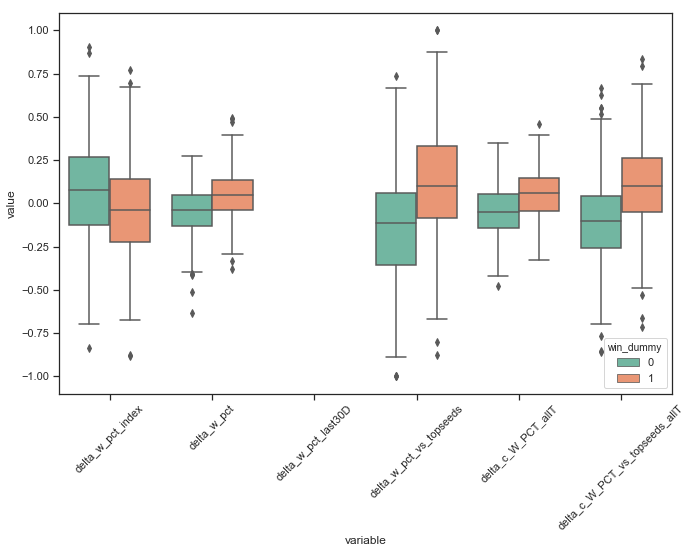

In [10]:
## > DATA VIZ TOURNEY 3
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_3 = df_tourn_cl_gr.loc[:,['win_dummy', 'delta_w_pct_index',
                                         'delta_w_pct', 'delta_w_pct_last30D',
                                         'delta_w_pct_vs_topseeds', 
                                         'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_3, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

In [ ]:
## > DATA VIZ TOURNEY 4
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr_4 = df_tourn_cl_gr.loc[:,['win_dummy',
                                         'delta_MOR', 'delta_POM', 'delta_SAG']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr_4, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

In [11]:
df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin(y_ok))].reindex()

df_tourn_cl_gr_ar = df_tourn_cl_gr.copy()

df_tourn_cl_gr_ar = df_tourn_cl_gr_ar.loc[:, ['win_dummy', 'delta_poss_m', 'delta_opp_poss_m',
                                              'delta_ass_ratio_m', 'delta_tov_ratio_m', 
                                              'delta_reb_rate_m',
                                              'delta_opp_true_fg_pct_m',
                                              'delta_off_rating_m', 'delta_def_rating_m',
                                              'delta_net_rating_m', 'delta_pace_m', 
                                              'delta_poss_s',
                                              'delta_opp_poss_s', 'delta_ass_ratio_s', 'delta_tov_ratio_s',
                                              'delta_reb_rate_s', 'delta_opp_true_fg_pct_s', 'delta_off_rating_s',
                                              'delta_def_rating_s', 'delta_net_rating_s', 'delta_pace_s',
                                              'delta_c_N_season',
                                              'delta_w_pct',
                                              'delta_w_pct_index',
                                              'delta_seed_int',
                                              'delta_w_pct_vs_topseeds', 'delta_c_N_champ_W',
                                              'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT',
                                              'delta_MOR', 'delta_POM', 'delta_SAG']].fillna(0)

df_ar = pd.melt(df_tourn_cl_gr_ar, id_vars='win_dummy')

df_ar.groupby(['variable']).apply(apply_somers).reset_index().sort_values(by=['Dxy'], ascending=False)

,variable,Dxy,C
8,delta_c_W_PCT_vs_topseeds_allT,0.475749,0.737874
11,delta_net_rating_m,0.466820,0.733410
30,delta_w_pct_vs_topseeds,0.433370,0.716685
13,delta_off_rating_m,0.394161,0.697081
28,delta_w_pct,0.384401,0.692201
7,delta_c_W_PCT_allT,0.383213,0.691607
5,delta_c_N_champ_W,0.277083,0.638541
4,delta_ass_ratio_s,0.262395,0.631198
23,delta_reb_rate_m,0.255624,0.627812
18,delta_opp_true_fg_pct_s,0.243458,0.621729


In [ ]:
df_tourn_cl_gr_corr = df_tourn_cl_gr.copy()

df_tourn_cl_gr_corr = df_tourn_cl_gr_corr.loc[:, ['win_dummy', 'delta_poss_m', 'delta_opp_poss_m',
                                       'delta_ass_ratio', 'delta_tov_ratio', 
                                       'delta_reb_rate',
                                       'delta_opp_true_fg_pct',
                                       'delta_off_rating_m', 'delta_def_rating_m',
                                       'delta_net_rating_m', 'delta_pace_m', 'delta_off_rating_m_last30D',
                                       'delta_def_rating_m_last30D', 'delta_net_rating_m_last30D',
                                       'delta_off_rating_m_vs_topseeds', 'delta_def_rating_m_vs_topseeds',
                                       'delta_net_rating_m_vs_topseeds', 'delta_c_N_season',
                                       'delta_w_pct', 'delta_w_pct_last30D',
                                       'delta_w_pct_vs_topseeds', 'delta_c_N_champ_W',
                                       'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT',
                                       'delta_MOR', 'delta_POM', 'delta_SAG']].fillna(0)

corr = df_tourn_cl_gr_corr.corr()
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap="YlGnBu", ax = ax)

In [12]:
## > SAVE
df_tourn_cl_gr.to_csv(path_datasets + '03Py_NCAA_dataset_con_indicatori.csv', sep = "|",
                      index=False)

In [ ]:
df_agg_stats.describe()

In [8]:
df_agg_stats.loc[df_agg_stats['TeamID'] == 1181, ['Season', 'TeamName', 'G',
                                                  'G_first30D', 'G_last30D', 
                                                  'w_pct', 'w_pct_first30D', 'w_pct_last30D', 'w_pct_index']]

,Season,TeamName,G,G_first30D,G_last30D,w_pct,w_pct_first30D,w_pct_last30D,w_pct_index
72,2003,Duke,30.0,19.0,11.0,0.800000,0.842105,0.727273,-0.114833
399,2004,Duke,32.0,22.0,10.0,0.843750,0.954545,0.600000,-0.354545
725,2005,Duke,30.0,20.0,10.0,0.833333,0.900000,0.700000,-0.200000
1055,2006,Duke,33.0,23.0,10.0,0.909091,0.956522,0.800000,-0.156522
1389,2007,Duke,32.0,24.0,8.0,0.687500,0.750000,0.500000,-0.250000
1726,2008,Duke,32.0,23.0,9.0,0.843750,0.956522,0.555556,-0.400966
2069,2009,Duke,34.0,24.0,10.0,0.823529,0.833333,0.800000,-0.033333
2416,2010,Duke,34.0,24.0,10.0,0.852941,0.833333,0.900000,0.066667
2763,2011,Duke,34.0,24.0,10.0,0.882353,0.916667,0.800000,-0.116667
3107,2012,Duke,33.0,24.0,9.0,0.818182,0.833333,0.777778,-0.055556
